<a href="https://colab.research.google.com/github/Marrie05/RhombixTechnologies_Tasks/blob/main/TITANIC_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make a system which tells whether the person will be save from sinking.
What factors were most likely lead to success-socio-economic status, age,
gender and more.

Survival prediction + feature-importance analysis (Titanic example)
Run with: pip install seaborn scikit-learn matplotlib pandas numpy

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, classification_report
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [ ]:
# 1) Load dataset (Titanic example)
df = sns.load_dataset("titanic")
df = df.copy()
df.head()

# 2) Quick target and available features
# Target: 'survived' (0 = died, 1 = survived)
# Candidate features: 'pclass' (SES proxy), 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'who', 'alone', 'adult_male'
df.columns.tolist()

# 3) Select features we want to use (you can expand)
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'alone']
target = 'survived'
data = df[features + [target]].copy()

# 4) Inspect missingness
print("Missing values:\n", data.isnull().sum())

# 5) Simple feature engineering
# - Socio-economic status proxy: use pclass (1 = highest SES) and fare (continuous)
# - family_size
data['family_size'] = data['sibsp'].fillna(0) + data['parch'].fillna(0) + 1

# 6) Final feature list
features_final = ['pclass','fare','age','sex','embarked','alone','family_size']
X = data[features_final].copy()
y = data[target].astype(int).copy()

Missing values:
 pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
alone         0
survived      0
dtype: int64


In [5]:
# 7) Train/test split (stratify on y to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 8) Preprocessing pipeline
numeric_features = ['fare','age','family_size']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['pclass','sex','embarked','alone']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# 9) Logistic Regression pipeline (interpretable)
logpipe = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# 10) Random Forest pipeline (stronger non-linear model)
rfpipe = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

# 11) Train models
logpipe.fit(X_train, y_train)
rfpipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fare', 'age',
                                                   'family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['pclass', 'sex', 'embarked',
                                                   'alone'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [6]:
   # 12) Evaluate
def evaluate(pipe, X_test, y_test, name="Model"):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    print(f"== {name} ==")
    print("Accuracy:", acc)
    print("ROC AUC :", roc)
    print("Classification report:\n", classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    return y_pred, y_proba

y_pred_log, y_proba_log = evaluate(logpipe, X_test, y_test, "Logistic Regression")
y_pred_rf,  y_proba_rf  = evaluate(rfpipe, X_test, y_test, "Random Forest")

# 13) Feature importance - Logistic Regression (coefficients)
# Need feature names after ColumnTransformer
ohe = logpipe.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_names)
coeffs = logpipe.named_steps['clf'].coef_[0]

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coeffs,
    'abs_coef': np.abs(coeffs)
}).sort_values('abs_coef', ascending=False)

print("\nLogistic Regression coefficients (sorted by absolute value):")
print(coef_df)

# 14) Permutation importance for Random Forest (gives importance magnitude)
# Use the preprocessed test data matrix to compute permutation importance
# Extract preprocessed arrays
X_test_trans = rfpipe.named_steps['preproc'].transform(X_test)
# Note: ColumnTransformer produced numeric + onehot columns in same order as feature_names
r = permutation_importance(rfpipe.named_steps['clf'], X_test_trans, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': r.importances_mean,
    'importance_std': r.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nPermutation importance (Random Forest):")
print(perm_df)

== Logistic Regression ==
Accuracy: 0.8044692737430168
ROC AUC : 0.8462450592885375
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.78      0.68      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Confusion matrix:
 [[97 13]
 [22 47]]
== Random Forest ==
Accuracy: 0.8044692737430168
ROC AUC : 0.8249011857707511
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.85       110
           1       0.77      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Confusion matrix:
 [[96 14]
 [21 48]]

Logistic Regression coefficients (sorted by absolute value)

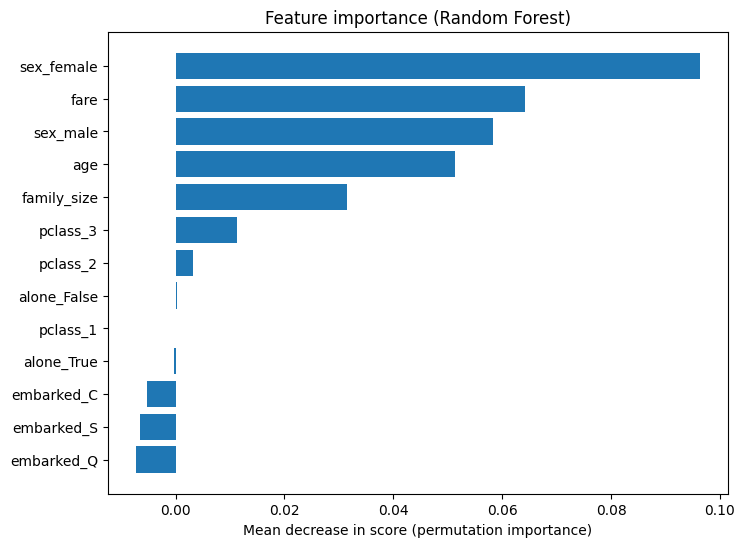

In [7]:
# 15) Plot permutation importance
plt.figure(figsize=(8,6))
plt.barh(perm_df['feature'], perm_df['importance_mean'])
plt.xlabel("Mean decrease in score (permutation importance)")
plt.title("Feature importance (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

In [8]:
# 16) Interpretation: combine both views
print("\nInterpretation guide:")
for idx, row in coef_df.head(8).iterrows():
    sign = "increases" if row['coefficient']>0 else "decreases"
    print(f" - {row['feature']}: {sign} probability of survival (logistic coef {row['coefficient']:.3f})")

print("\nTop features by random-forest importance:")
print(perm_df.head(8))


Interpretation guide:
 - sex_female: increases probability of survival (logistic coef 1.340)
 - sex_male: decreases probability of survival (logistic coef -1.218)
 - pclass_1: increases probability of survival (logistic coef 1.015)
 - pclass_3: decreases probability of survival (logistic coef -1.005)
 - family_size: decreases probability of survival (logistic coef -0.478)
 - age: decreases probability of survival (logistic coef -0.466)
 - embarked_Q: increases probability of survival (logistic coef 0.365)
 - alone_False: increases probability of survival (logistic coef 0.350)

Top features by random-forest importance:
        feature  importance_mean  importance_std
6    sex_female         0.096276        0.023732
0          fare         0.064246        0.021673
7      sex_male         0.058287        0.020887
1           age         0.051397        0.015495
2   family_size         0.031471        0.010647
5      pclass_3         0.011359        0.014095
4      pclass_2         0.0031

In [9]:
# 17) Example: predict probability for a new passenger
example = pd.DataFrame([{
    'pclass': 1,   # 1 = first class (higher SES)
    'fare': 100.0,
    'age': 30,
    'sex': 'female',
    'embarked': 'S',
    'alone': False,
    'family_size': 1
}])
prob = rfpipe.predict_proba(example)[0,1]
print(f"\nExample passenger predicted survival probability (Random Forest): {prob:.3f}")


Example passenger predicted survival probability (Random Forest): 1.000
